Recently I've been wanting to get into RL. I was the Berkeley deep RL bootcamp a few months back, learned a lot, and it's inspired me to start running my own expermients. I've already implemented a few advanced algorithms but I'm far from where I want to be in terms of practical RL skill. This blog series will be about acquiring and making sure I understand these concepts. The benefit to you from reading this is that get to hitch a ride and learn things wihtout all the editing work required to write a post like this. This post is targeteed at programmers or at least those with some python knowledge.

Thanks to openai for guidance on [their post](https://openai.com/requests-for-research/#cartpole). We will be followig that starting guide in this notebook. Thanks to kevin frans for covering this topic.  Helped me a lot. The goal here is to improve on what both have done to make sure the example code runs relaibly. I want to keep this from being too sripty and make sure the code stays small. I also want the final code example to be consistent.

# What is reinforcement learning (RL)?

You can find al ot of defintions online but I'd like to put mine here. RL is basically the process of teaching an 'agent' about the world. You tech them the constraints of this world, you teach them what is good and bad (reward function). then the agent takes these constraints and the reward function and explores its world, eventually realizing that exploring is less good than getting rewards. This last part is what RL researcher usually refer to as creating a "policy." A policy is a formula that tells the agent what it shold do in every state of the world. As you can imagine for large worlds a policy can get prohibitively large so often times an approcimation of whatever your agent is maximizing is used (like in DQNs). The sort of side effect of this process is that over time the agent learns how to play in this world. When an agent has learned how to play well we say that the agent has found an optimal policy. RL is the process of finding an optimal policy for a partciular agent in a particular world. 

We will start RL by examining the simplest method for finding an optimal (or good enough) policy: Randomly guessing policy parameters.

In [1]:
import gym
import numpy as np

Many times RL agents are trained inside games. Games are simple representations of a world; they are also called 'environments.' We will use the [cartpole](https://gym.openai.com/envs/CartPole-v0/) [environment](https://gym.openai.com/docs/) from openai. This envornment is nothing exotic. It is a python object that represents our game world that we can call methods to get inforamtion from like 'what is the world state currently?' or 'is the game over (did we lose or win)?' You can also call this object to perform actions on the environment. Thes environments are located inside openai `gym`.

Let's see how many actions are in the cartpole environment.

In [2]:
env = gym.make('CartPole-v0')
print(env.action_space, env.observation_space)

Discrete(2) Box(4,)


# Policy Search One: Random Guessing

The cartpole action space has 2 values (`0` and `1`, left and rigt) and the observation space, what we can see about the world, has 4 values (representing dirctional speeds and angles of our pole and cart). Our policy will be to randomly guess 4 numbers, multiply them by the 4 numbers from the cartpole observation and if the result is less than zero is will do action 0, and if its greater or equal to zero it will do action 1.

In [3]:
# pick 4 random numbers 
# normalize these numbers to be between -1 and 1
def get_random_policy_parameters():
    policy_parameters = np.random.rand(4)
    return (policy_parameters - 0.5) * 2

# our policy tells us what action to take given
# the current world state
# and the current parameters of our policy
def policy(policy_parameters, observation):
    return 0 if np.matmul(policy_parameters, observation) < 0 else 1

In [4]:
# get random policy parmaeters 
# get the initial observation
# from the cartpole environment
params = get_random_policy_parameters()
observation = env.reset()
policy(params, observation)

0

If you run the above cell a few times yoru should see our policy choose 0 or 1. Remember this is a random policy so there's no real rhym or reason here and you shouldnt expect a random policy to work that well or work well after a few iterations. The magic happens i the next part where we search random policies until we find a decent one.

In [5]:
# define a single 'run' of our learning algorithm
def run_episode(env, policy_parameters):
    observation = env.reset()
    total_reward = 0
    # take 200 actions in the environment
    for _ in range(200):
        action = policy(policy_parameters, observation)
        observation, reward, done, info = env.step(action)
        total_reward += reward
        # end this episode if the game is done
        if done:
            break
    return total_reward

We want to search for the random policy with the highest total reward. 

In the cartpole environment the game can go on forever. We are going to say that if our agent can keep the cartpole standing for 200 steps it has won the game. The rewards in this environment are +1 and -1 so the largest reward our agent can hope to get is +200 (+1 for every time step in an episode).

This code tries 10,000 random policies, and will end once one of those policies gets to 200 reward.

In [6]:
def random_search(env):
    all_rewards = []
    num_episodes = 0
    
    best_params = None  
    best_reward = 0  

    for _ in range(10000):
        num_episodes += 1
        params = get_random_policy_parameters()
        reward = run_episode(env, params)
        all_rewards.append(reward)
        if reward > best_reward:
            best_reward = reward
            best_params = params
            if reward == 200:
                break
    return best_params, best_reward, all_rewards, num_episodes

search_result = random_search(env)
search_result[0], search_result[1]

(array([-0.00939306,  0.09025247,  0.92559672,  0.96015534]), 200.0)

As you can see we have found a policy that can achieve 200 reward (last 200 steps in the environment). Let's visualize an agent playing with this policy for 200 steps.

In [7]:
def watch_agent_play_with_policy(policy_parameters):
    observation = env.reset()
    while True:
        env.render()
        action = policy(policy_parameters, observation)
        observation, _, done, _ = env.step(action)
        if done:
            break
    env.render(close=True)
watch_agent_play_with_policy(search_result[0])

Ok so our agent with this policy can actually play polecart for 200 steps! That is kinda neat. Let's visualize how efficient this random search method is. We wnat to know how many episoeds it takes to get to 200 reward. to do this we'll run the random search process 100x. And store the number of episodes from each run.

In [8]:
episodes_per_search = []
for _ in range(100):
    best_params, best_reward, all_rewards, num_episodes = random_search(env)
    episodes_per_search.append(num_episodes)

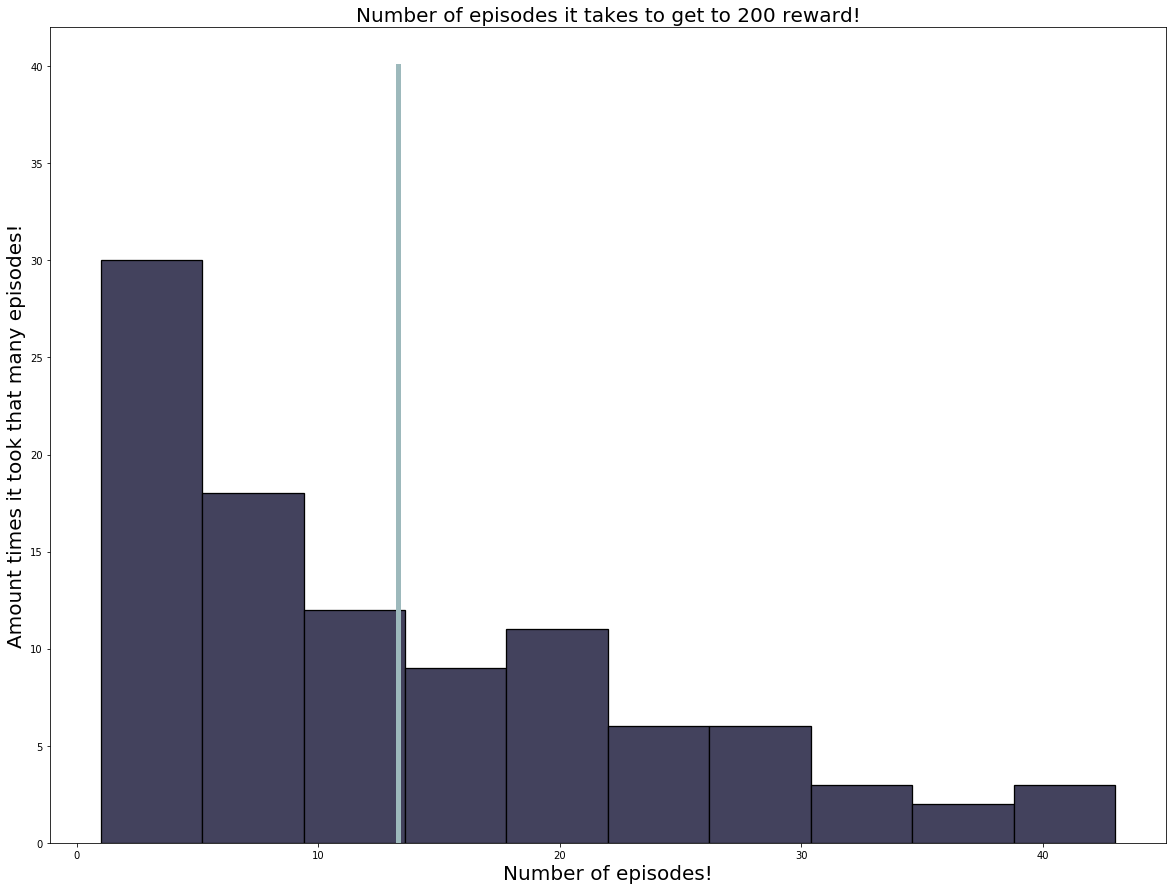

average number of episodes: 13.29


In [9]:
import matplotlib.pyplot as plt

color = plt.get_cmap('bone')
avg = np.mean(episodes_per_search)

plt.figure(figsize=(20,15))
plt.hist(episodes_per_search, color=color(0.3), edgecolor='black', linewidth=1.3)
plt.plot([avg for _ in range(40)], np.linspace(0,40,40), color=color(0.7), linewidth=5)
plt.title('Number of episodes it takes to get to 200 reward!', fontsize=20)
plt.xlabel('Number of episodes!', fontsize=20)
plt.ylabel('Amount times it took that many episodes!', fontsize=20)
plt.show()

print('average number of episodes: {}'.format(avg))

Ok so this process is actually not too bad. The mean time to find 200 reward was aound 12-13 episodes. We've explored this enough. Let's look at the next step on openai's guide.

# Policy Search Two: Hill Climbing Algorithm

The idea behind the hill climbing algorithm is that reward is a function of your parameters and when you start with a rando mpolicy you are at a local minimum of this function. To imporve your policy you wand to 'climb' up this function and geta  better reward. The way you do this is by choosing a random policy parameters like before to start and then adding noise (small changes) to them. If the noise improves your reward you update your parameters to incorporate that noise, otherwise you try to test different random noise. Those or you familiar with gradient descent will probabl yunderstand this method. Hill climbing is similar to gradient descent.

The idea is that if you keep doing this you will move your policy parameters towards a higher and higher reward. here is a graphic showing this:

![The Hill Climbing Algorithm](hill_climbing.png)

This function adds some noise to the parameters the scaling parameter just lowers the noise values so they are smaller and not just regular random values.

In [10]:
def noise_params(params, noise_scaler):
    return params + (np.random.rand(4) - 0.5) * 2 * noise_scaler

In [11]:
noise_scaler = 0.1

def run_episode_hill(env):
    params = get_random_policy_parameters()
    best_reward = 0
    num_episodes = 0
    all_rewards = []

    for _ in range(10000):
        num_episodes += 1
        new_params = noise_params(params, noise_scaler)
        reward = run_episode(env, new_params)
        all_rewards.append(reward)
        
        if reward > best_reward:
            best_reward = reward
            params = new_params
            if reward == 200:
                break
    return params, best_reward, all_rewards, num_episodes

In [12]:
params, best_reward, all_rewards, num_episodes = run_episode_hill(env)
params, best_reward, sum(all_rewards), num_episodes

(array([ 0.18819117, -0.3758361 ,  0.67345755,  0.92728565]), 200.0, 200.0, 1)

On first glance this seems less good. It looks like we got to 200 reward (that's good) but it took 730 eisodes episodes to get a reward like this. Let's run a bunch of erperiments and see how many episodes it takes to find this solution.

In [13]:
episodes_per_search = []
rewards_per_episode = []
for _ in range(100):
    result = run_episode_hill(env)
    num_eps = result[3]
    reward = result[1]
    episodes_per_search.append(num_eps)
    rewards_per_episode.append(reward)

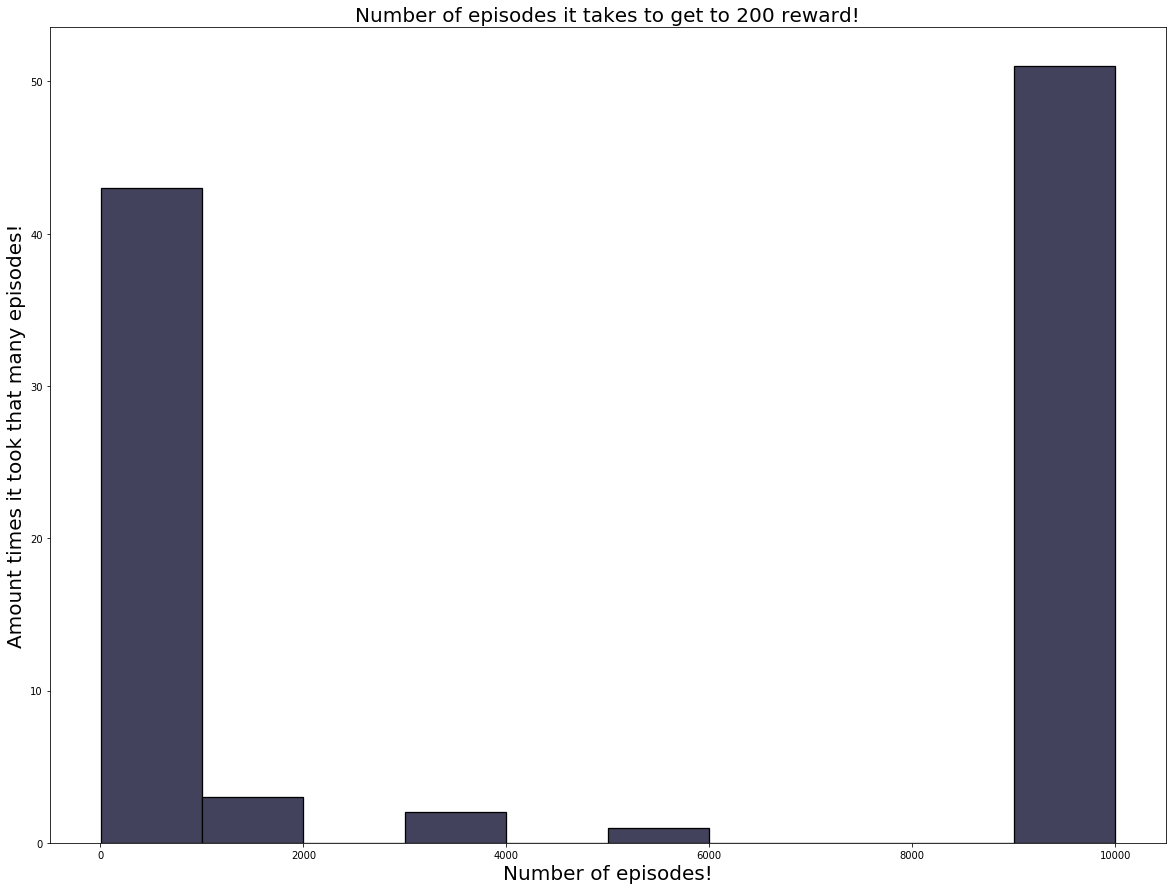

In [14]:
episodes_per_search = np.array(episodes_per_search)

plt.figure(figsize=(20,15))
plt.hist(episodes_per_search, color=color(0.3), edgecolor='black', linewidth=1.3)
plt.title('Number of episodes it takes to get to 200 reward!', fontsize=20)
plt.xlabel('Number of episodes!', fontsize=20)
plt.ylabel('Amount times it took that many episodes!', fontsize=20)
plt.show()

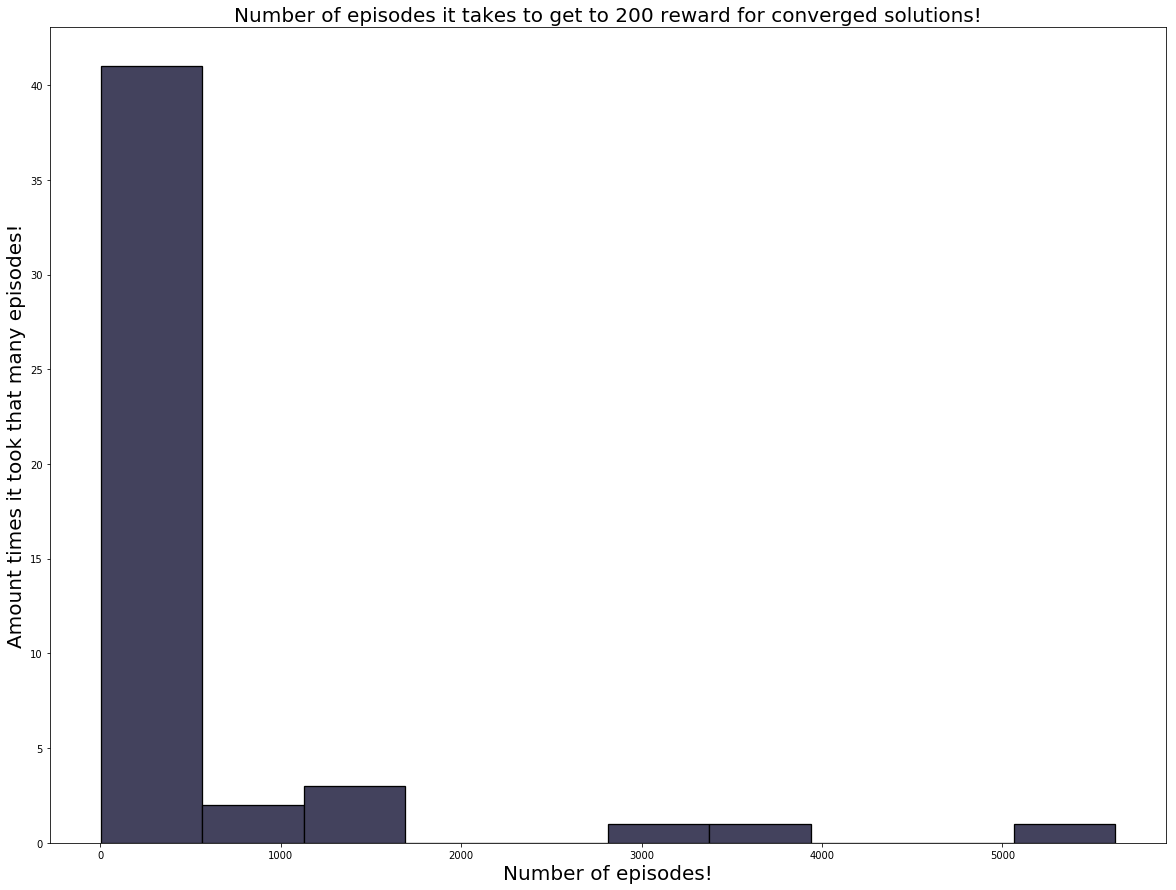

In [15]:
rewards_per_episode = np.array(rewards_per_episode)
eps_200 = episodes_per_search[np.where(rewards_per_episode == 200)[0]]

plt.figure(figsize=(20,15))
plt.hist(eps_200, color=color(0.3), edgecolor='black', linewidth=1.3)
plt.title('Number of episodes it takes to get to 200 reward for converged solutions!', fontsize=20)
plt.xlabel('Number of episodes!', fontsize=20)
plt.ylabel('Amount times it took that many episodes!', fontsize=20)
plt.show()

As you can see above some experiments run for 10,000 episodes. If we check the best_rewards array for each of those we would see that most of those runs that take 10K episodes fail to accumulate much reward at all.

Why is this happening? Imagine instead of having a single hill there are dozens of hils of different sizes for different policies and flat plains in between those hills. Well it turns out that if your hill climbing algorithm starts out on a flat plane adding noise to those parameters doesn't change the reward. In other words, we move around randomly near a point but never find any better rewards and so never start climbing a hill. 

Another thing that seems to be happening is that sometimes we find a policy that converges to 200 reward but does so very slowly and takes several thousand iterations. this imples that for some reason our policy is moving in the wrong direction before moving back and converging.

**Change 1**:

One way to deal with our first problem is to increase the `noise_scaler` value or we could increase the noise scaler factor if our reward stagnates for too long.

**Change 2**:

A way to deal with our second problem is to evaluate a potential policy change in the environment a few times and take the cumulative reward of all those tries. This takes longer but gives us a more accurate idea of how good an action is.

Let's implement change 1 and update our experiments. We will increase our noise scaler by 0.2 * the number of runs squared for every run we don't improve. We will also add a new constant that runs the action in the environment more than once to evaluate a policy.

In [16]:
def run_episode_hill_improved(env, runs_per_action):
    noise_scaler = 0.1
    runs_since_improvement = 0
    params = get_random_policy_parameters()
    best_reward = 0
    num_episodes = 0
    all_rewards = []

    for _ in range(10000):
        runs_since_improvement += 1
        num_episodes += 1
        new_params = noise_params(params, noise_scaler)
        reward = np.sum([run_episode(env, new_params) for _ in range(runs_per_action)])
        all_rewards.append(reward)
        
        if reward > best_reward:
            best_reward = reward
            params = new_params
            if reward == 200*runs_per_action:
                break
            runs_since_improvement = 0
            noise_scaler -= 0.2 * runs_since_improvement**2
        else:
            runs_since_improvement += 1
        
        if runs_since_improvement > 1:
            noise_scaler += 0.2 * runs_since_improvement**2
    return params, best_reward, all_rewards, num_episodes

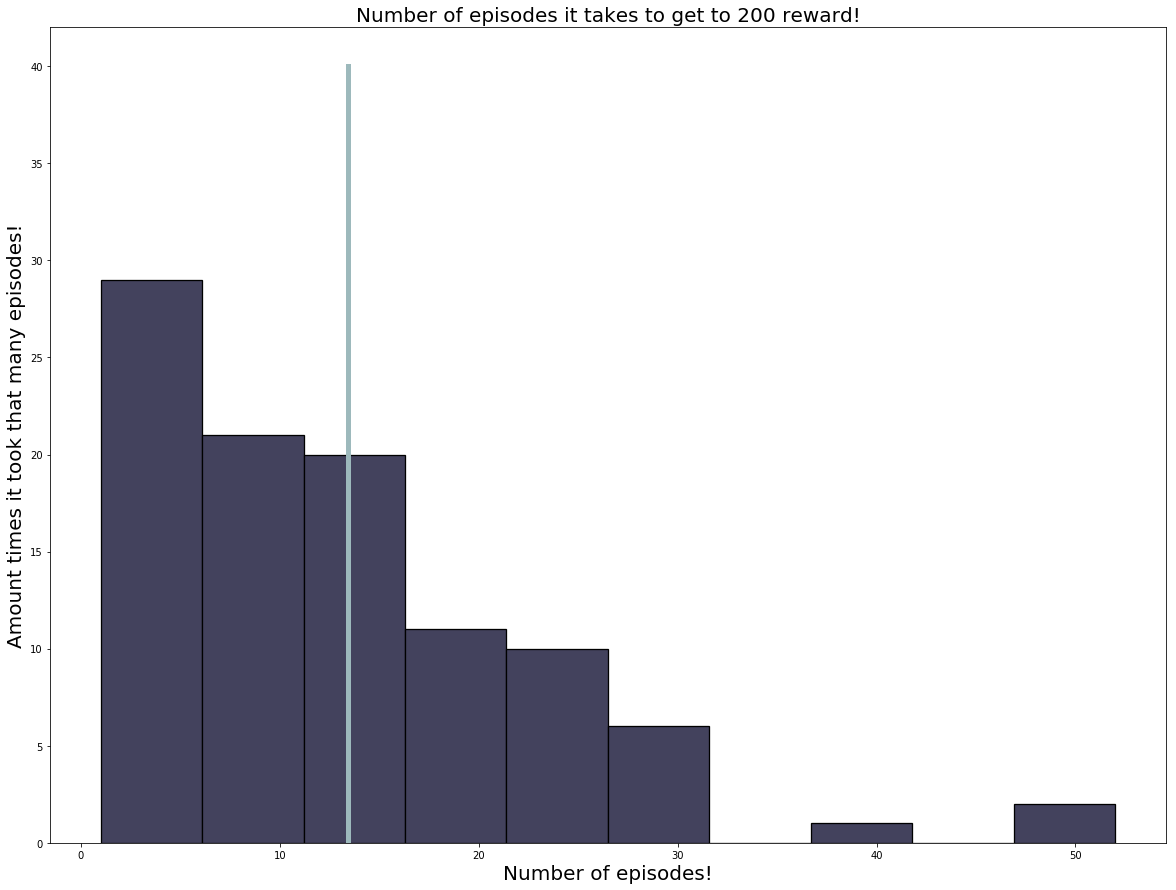

average number of episodes: 13.41


In [17]:
episodes_per_search = []
rewards_per_episode = []
for _ in range(100):
    result = run_episode_hill_improved(env, 1)
    num_eps = result[3]
    reward = result[1]
    episodes_per_search.append(num_eps)
    rewards_per_episode.append(reward)

avg = np.mean(episodes_per_search)

plt.figure(figsize=(20,15))
plt.hist(episodes_per_search, color=color(0.3), edgecolor='black', linewidth=1.3)
plt.plot([avg for _ in range(40)], np.linspace(0,40,40), color=color(0.7), linewidth=5)
plt.title('Number of episodes it takes to get to 200 reward!', fontsize=20)
plt.xlabel('Number of episodes!', fontsize=20)
plt.ylabel('Amount times it took that many episodes!', fontsize=20)
plt.show()
print('average number of episodes: {}'.format(avg))

As you can see the average number of episodes is now better than in random search. Increasing the number of times an episode is run does not appeas to be very helpful. Though you'd think it would be...

# Policy Search Three: Policy Gradients

Policy gradients are cutting edge RL. In following this blog you'll be touching the edge of known RL research. Cool huh? So what is the policy gradient algorithm?

It works like this:

policy -> action -> rewards + new states -> value -> value_function update 
                                                   -> advantages -> policy_function update

then the cycle repeats.

We start with a policy and then take a series of actions. We then use the results of those actions (the rewards) to craete a value function which tells us the value of particular states. We then see how much reward we would get from taking a particular series of actions  minus what our current value function tells us we would get from taking that series of actions. This is called th eadvantage and it is used to incraese the porbability of actions that are returning more than our vaue function says they should. We use it to update our policy. Then we repeat this process. Eventually we learn a value function taht has a good idea about which states are good, and we get a policy that is good at maximizing its reward.

We will use tensorflow to make our policy gradient algorithm. This post is nto a tensorflow tutorial. You should look one of those up if you need to learn or review theses concepts. The first thing we are going to do is given a policy, use that policy to play through one episode. We will call this process 'building transitions.' Really this just takes our current policy and plays the game until it wins or loses, gnerating data we will use to imporve our policy and value function.  Let's do it.

In [18]:
import gym
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def build_transitions(world_state, p_probs, p_state, sess):
    total_reward = 0
    states = []
    actions = []
    transitions = []
    # build transitions, this generates
    # a sequence of actions, states,
    # and the rewards between each
    for _ in range(200):
        # run the current policy with the
        # observation from the environment
        # record the action the policy recommends
        state_vector = world_state.reshape(1, -1)
        result = sess.run(p_probs, feed_dict={p_state: state_vector})
        probs = result[0][0]
        action = policy(probs)
        states.append(world_state)
        action_taken = np.zeros(2)
        action_taken[action] = 1
        actions.append(action_taken)
        
        # take the action in the environment
        # and record a transition that describes
        # the state, action, and reward received
        old_state = world_state
        world_state, reward, done, info =  env.step(action)
        transitions.append((old_state, action, reward))
        
        #cumulate the total reward for this episode
        total_reward += reward
        
        # stop playing if the game ends
        if done:
            break
    return transitions, states, actions, total_reward, world_state

Next we will learn a 'value function' this value function is a neural net that learns how valuable a future state is from the current state.

In [19]:
def get_values_and_advantages(v_vals, v_state, world_state, transitions, sess):  
    advantages = []
    update_vals = []
    # build the value function and calculate
    # advantages from the transitions
    for i, transition in enumerate(transitions):
        obs, act, rew = transition
        
        discount = 0.03
        decrease = 1
        future_reward = 0
        
        # go through the rest of the of the transitions
        # and grab the rewards and create a discounted
        # total rewards, from this transition onward
        for future_transition in transitions[i:]:
            future_reward += future_transition[2] * decrease
            decrease = decrease * (1 - discount)
            
        # get the current prediction for the next state
        # using our value function
        state_vector = world_state.reshape(1, -1)
        values_current = sess.run(v_vals, feed_dict={v_state: state_vector})
        
        # add the future reward to
        # a list so we can use it to
        # improve our value function
        update_vals.append(future_reward)
        
        # record how much better taking this action is
        # over how good it usually is, this will be used
        # to update our policy. as our value functon gets better
        # the advantage of the correct actions to take in various 
        # states will increase, we will use these advantages to
        # increase the probability that our policy selects those actions
        advantages.append(future_reward - values_current[0][0])
    return update_vals, advantages

This is doing a few things:

1 - It goes thorugh every transition and for every transition it loops through the rest of the steps until it gets through all of them. Fof the current transition it calculates the future reward. These future rewards are used as labels to improve our value function. We get an N sized array of labels called `update_vals` that we use as labels for the value function (where N is the number of transitions).

2 - It calculates the difference between future rewards we experienced when building the transitions (playing the game) and the rewards our value function said we should accrue. If the difference is positive we want our policy to do actions that lead to that states more. If negative we want our policy to do actions that lead ot that state less. There values are called the 'advantage' and they are used to do this in the `policy_gradient` method below. What this does is say "ok the value functio nis telling me X is worth 5, but I see that it's actually worth 25, so i should update my policy to increase my probability of taking an action that will put me in state X." This information will also pass into the value function via the `update_vals` array.

Next we will drescibe two functions that update the value function and update the policy.

In [20]:
# update our value function by running its optimizer
def update_value_function(update_vals, v_optimizer, v_state, v_new_vals, states, sess):
    update_vals_vector = np.array(update_vals).reshape(-1, 1)
    sess.run(v_optimizer, feed_dict={v_state: states, v_new_vals: update_vals_vector})

# update our policy using the advantage, run its optimizer
def update_policy(advantages, p_optimizer, p_state, p_advantages, p_actions, states, actions, sess):
    advantages_vector = np.array(advantages).reshape(-1, 1)
    sess.run(p_optimizer, feed_dict={p_state: states, p_advantages: advantages_vector, p_actions: actions})

Nex we will define two functions:
```
value_function
policy
```

`value_function` has two purposes: it can be run to produce values for states returned by `calc_vals` (see `values_current` above in `get_values_and_advantages`) or it can be trained/improved by passing in `update_vals` and calling v_optimizer as above.

`policy` has 2 functions. The first it can produce an action using the current policy if it is given the state (see `action` in `build_transitions` above). It can also improve the state if p_optimizer is called as above in `update_policy`.

In [21]:
def value_function():
    with tf.variable_scope("value"):
        state = tf.placeholder(tf.float32,[None,4])
        update_vals = tf.placeholder(tf.float32, [None, 1])

        w = tf.get_variable("w1",[4, 10])
        b = tf.get_variable("b1",[10])
        logits = tf.matmul(state, w) + b
        h = tf.nn.relu(logits)
        w = tf.get_variable("w2",[10, 1])
        b = tf.get_variable("b2",[1])
        calc_vals = tf.matmul(h,w) + b

        diffs = calc_vals - update_vals
        loss = tf.nn.l2_loss(diffs)
        optimizer = tf.train.AdamOptimizer(0.1).minimize(loss)
        
        return calc_vals, state, update_vals, optimizer, loss

def policy_function():
    with tf.variable_scope("policy"):
        params = tf.get_variable("policy_parameters", [4, 2])
        state = tf.placeholder(tf.float32, [None, 4])
        actions = tf.placeholder(tf.float32, [None, 2])
        advantages = tf.placeholder(tf.float32, [None, 1])
        
        policy_function = tf.matmul(state, params)
        probs = tf.nn.softmax(policy_function) 
        good_probs = tf.reduce_sum(tf.multiply(probs, actions), reduction_indices=[1])
        log_probs = tf.log(good_probs) * advantages
        loss = -tf.reduce_sum(log_probs)
        
        optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)
        return probs, state, actions, advantages, optimizer
    
def policy(probs):
    return 0 if random.uniform(0,1) < probs else 1

Now we have all the parts:

A value function and a policy function. (`value_function`, `policy`)

A framework to play the game and record information. (`build_transitions`, `get_values_and_advantages`)

Th eability to use that information to update the policy and value function. (`update_policy`, `update_value_function`)

We can put them together into a method called `run_episode` as before:

In [22]:
def run_episode(env, sess, policy_vars, value_vars):
    # load tensorflow variables that have been initialized
    p_probs, p_state, p_actions, p_advantages, p_optimizer = policy_vars
    v_vals, v_state, v_new_vals, v_optimizer, v_loss = value_vars
    
    # reset the environment
    world_state = env.reset()
    # play the game and get transitions, states, actions, reward
    # for playing this episode
    transitions, states, actions, total_reward, world_state = build_transitions(world_state, p_probs, p_state, sess)
    # get information needed to update policy/valuefunction
    update_vals, advantages = get_values_and_advantages(v_vals, v_state, world_state, transitions, sess)
    # update value_function and policy
    update_value_function(update_vals, v_optimizer, v_state, v_new_vals, states, sess)
    update_policy(advantages, p_optimizer, p_state, p_advantages, p_actions, states, actions, sess)
    
    # return the total reward for this episode
    return total_reward

In [23]:
# create a cartpole environment
env = gym.make('CartPole-v0')

def run_cartpole(episodes, early_stop=True):

    # reset the tensorflow graph and create
    # a new graph for our value function
    # and our policy
    tf.reset_default_graph()
    policy_vars = policy_function()
    value_vars = value_function()

    # create a new tensorflow session
    # and intialize our variables
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    
    eps_to_converge = 0
    # run some episodes with the method above
    rewards = []
    for _ in range(episodes):
        eps_to_converge += 1
        reward = run_episode(env, sess, policy_vars, value_vars)
        rewards.append(reward)
        if early_stop and reward == 200:
            break
    return sess, rewards, eps_to_converge

In [24]:
sess, rewards, eps = run_cartpole(2000)

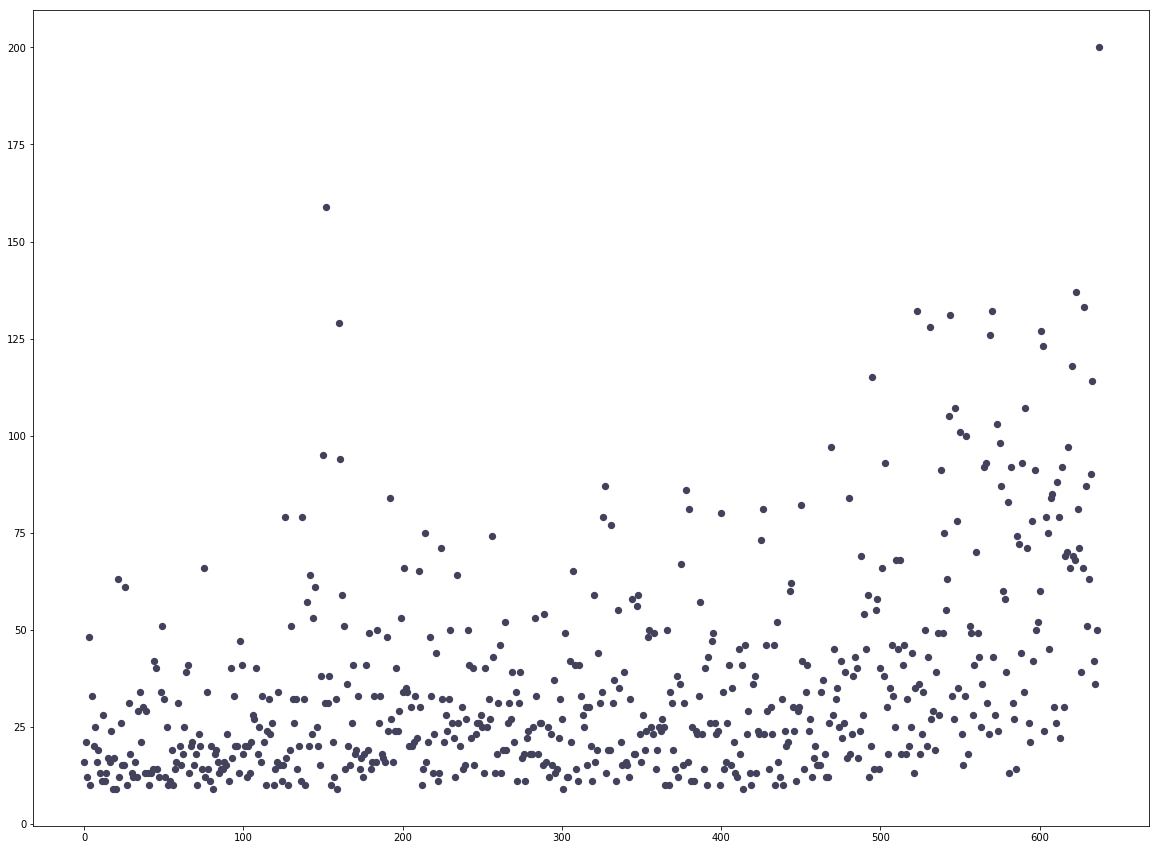

In [25]:
import matplotlib.pyplot as plt

color = plt.get_cmap('bone')

plt.figure(figsize=(20,15))
plt.scatter([x for x in range(len(rewards))], rewards, color=color(0.3), linewidth=1.3)
plt.show()

Let's run a quick exepriment to see the distribution of how long it takes for our policy gradient to converge.

In [26]:
# this takes 10-20 min to run.
episodes_to_converge = []
for _ in range(100):
    sess, reward, eps = run_cartpole(2000)
    episodes_to_converge.append(eps)
    if not _ % 10:
        print(_)

0
10
20
30
40
50
60
70
80
90


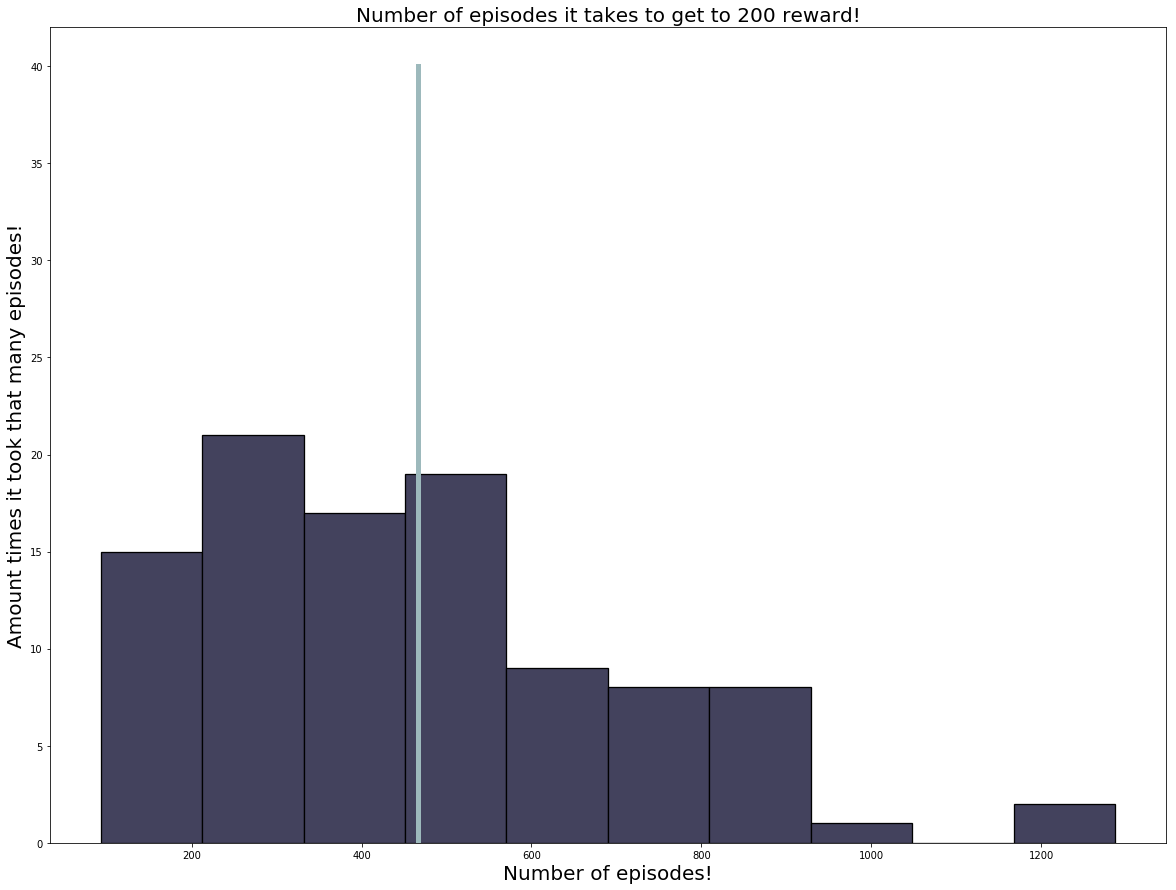

avg number of episodes: 466.94


In [27]:
import matplotlib.pyplot as plt

color = plt.get_cmap('bone')
avg = np.mean(episodes_to_converge)

plt.figure(figsize=(20,15))
plt.hist(episodes_to_converge, color=color(0.3), edgecolor='black', linewidth=1.3)
plt.plot([avg for _ in range(40)], np.linspace(0,40,40), color=color(0.7), linewidth=5)
plt.title('Number of episodes it takes to get to 200 reward!', fontsize=20)
plt.xlabel('Number of episodes!', fontsize=20)
plt.ylabel('Amount times it took that many episodes!', fontsize=20)
plt.show()

print('avg number of episodes: {}'.format(avg))

# Extras, Running, Watching our Policy

The natural inclination now is to try and extract the policy parameters
from tensorflow and run the algorithm like so: 

```python
with tf.variable_scope("policy", reuse=True):
    policy_parameters = sess.run(tf.get_variable("policy_parameters", [4, 2]))
```

But in tensorflow as long as we keep the graph around in the `sess` variable the parameters are there and can be accessed by using the variable scope and passing in `reuse=True`. So there is no need to do the above. We can modify our policy_gradient functio to make a `run_policy` function which will automatically use the policy parameters we've optimized.

In [28]:
# run the policy in tensorflow
def run_policy():
    with tf.variable_scope("policy", reuse=True):
        params = tf.get_variable("policy_parameters", [4, 2])
        state = tf.placeholder(tf.float32, [None, 4])
        actions = tf.placeholder(tf.float32, [None, 2])        
        policy_function = tf.matmul(state, params)
        probs = tf.nn.softmax(policy_function) 
        good_probs = tf.reduce_sum(tf.multiply(probs, actions), axis=1)
        log_probs = tf.log(good_probs)        
        return probs, state, actions

In [30]:
episode_counter = 0
total_reward = 0
probs, state, actions = run_policy()
world_state = env.reset()

while True:
    env.render()
    prob = sess.run(probs , feed_dict={state: world_state.reshape(1, -1)})
    action = 0 if random.uniform(0,1) < prob[0][0] else 1
    world_state, reward, done, _ = env.step(action)
    total_reward += reward
    if done:
        if episode_counter == 100:
            break
        episode_counter += 1
        world_state = env.reset()
env.render(close=True)

In [31]:
'reward over 100 periods: {}'.format(total_reward / 100)

'reward over 100 periods: 105.1'